In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../../assets/huggingface_with_fairness.csv")

In [5]:
features = ['performance_score', 'co2_eq_emissions']
df_cluster = df[features].dropna()

# 2. Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(df_scaled, columns=features)

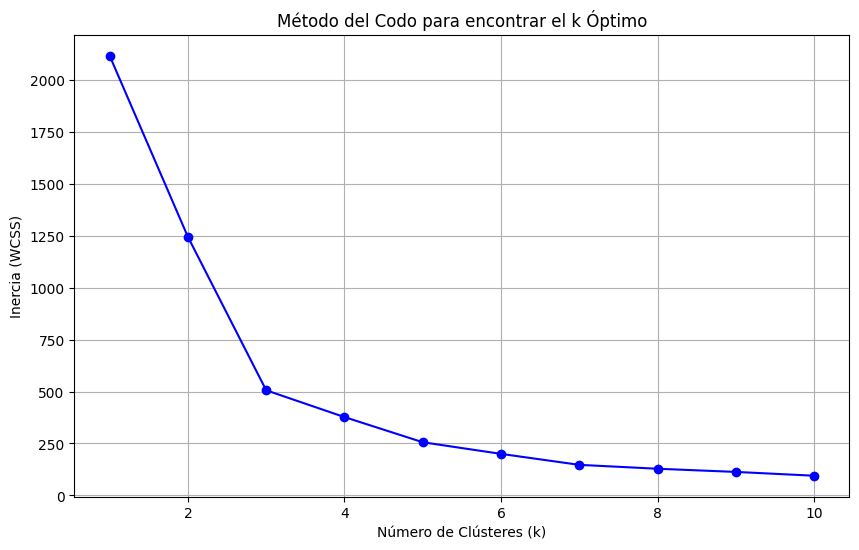

In [6]:
inertia = []
K = range(1, 11) # Probaremos con k desde 1 hasta 10

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # n_init=10 es para robustez
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para encontrar el k Óptimo')
plt.grid(True)
plt.show()

In [7]:
optimal_k = 3

# Ejecutar K-Means con el número óptimo de clústeres
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Añadir la asignación de clústeres al DataFrame original
df_cluster['kmeans_cluster'] = clusters

print(f"\nSe han asignado los datos a {optimal_k} clústeres.")
print(df_cluster.head())


Se han asignado los datos a 3 clústeres.
   performance_score  co2_eq_emissions  kmeans_cluster
0           0.513276        133.021988               1
1           0.602463        126.344463               1
2           0.961060          7.989145               0
3           0.929787         55.101963               0
4           0.778492        123.880231               0



--- Resumen de Características por Clúster (K-Means) ---
                performance_score  co2_eq_emissions
kmeans_cluster                                     
0                        0.884827         16.815551
2                        0.409739       2792.059033
1                        0.364463         90.652209


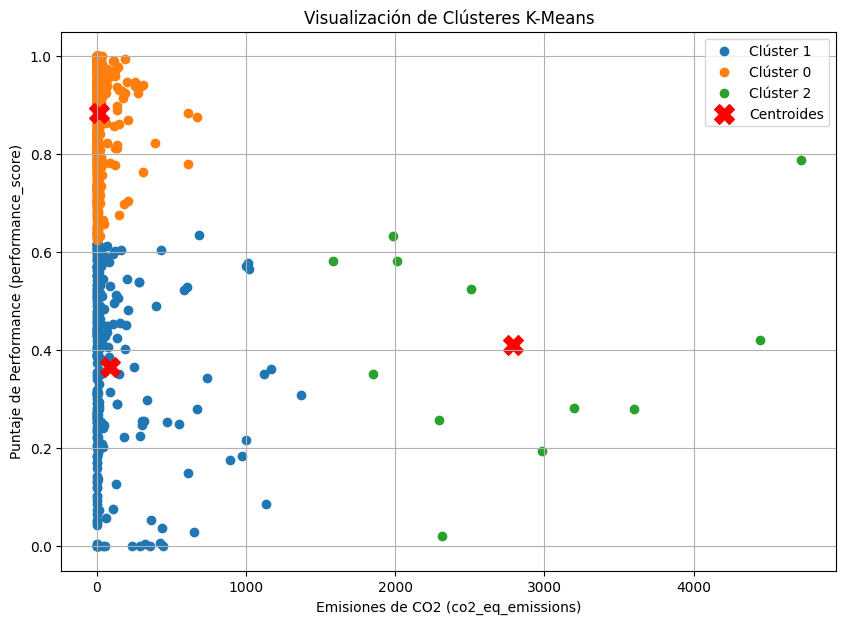

In [8]:
# Agrupar por clúster y calcular la media de las características
kmeans_summary = df_cluster.groupby('kmeans_cluster')[features].mean().sort_values(by='performance_score', ascending=False)

print("\n--- Resumen de Características por Clúster (K-Means) ---")
print(kmeans_summary)

# Visualizar los clústeres
plt.figure(figsize=(10, 7))
# Usamos df_scaled para obtener las coordenadas de los centroides
centers_scaled = kmeans.cluster_centers_ 
# Revertimos la estandarización para graficar los centroides en la escala original
centers = scaler.inverse_transform(centers_scaled)

# Graficar los puntos de cada clúster
for cluster_id in df_cluster['kmeans_cluster'].unique():
    subset = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]
    plt.scatter(subset['co2_eq_emissions'], subset['performance_score'], label=f'Clúster {cluster_id}')

# Graficar los centroides
plt.scatter(centers[:, 1], centers[:, 0], s=200, c='red', marker='X', label='Centroides')

plt.title('Visualización de Clústeres K-Means')
plt.xlabel('Emisiones de CO2 (co2_eq_emissions)')
plt.ylabel('Puntaje de Performance (performance_score)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

## Interpretación de Cada Clúster
#🏆 Clúster 0 (Naranja): Los Modelos Ideales
#Posición: Este grupo se encuentra en la esquina superior izquierda.

#Significado: Tiene un alto puntaje de performance (eje Y) y muy bajas emisiones de CO2 (eje X).

#Conclusión: Estos son tus mejores modelos. Son altamente eficientes, logrando los mejores resultados con el mínimo impacto ambiental. Deberías estudiar qué características tienen en común estos modelos para replicar su éxito.

#✅ Clúster 1 (Azul): Los de Bajo Impacto pero Rendimiento Moderado
#Posición: Se agrupa en la parte inferior izquierda.

#Significado: Tiene un performance de bajo a moderado pero también mantiene bajas emisiones de CO2.

#Conclusión: Este es el grupo más numeroso. No son los de mejor rendimiento, pero al menos son ecológicos. Representan un "estándar" o una línea base. El objetivo podría ser encontrar maneras de mejorar su performance sin aumentar significativamente sus emisiones.

#⚠️ Clúster 2 (Verde): Los de Alto Costo Ambiental
#Posición: Se extiende hacia la derecha del gráfico.

#Significado: Tiene un performance moderado, pero a cambio de emisiones de CO2 extremadamente altas.

#Conclusión: Estos son los modelos ineficientes. El costo ambiental que pagan es desproporcionado para el rendimiento que ofrecen. Generalmente, estos son los modelos que deberías evitar, optimizar para reducir su huella de carbono, o usar solo si su performance es absolutamente crítico y no hay alternativa.

## En Resumen
#Tu análisis de K-Means ha segmentado exitosamente tus modelos en tres categorías claras y útiles:

#Ideales (Naranja): Alto rendimiento, bajo costo. El objetivo a seguir.

#Base (Azul): Rendimiento modesto, bajo costo. Un punto de partida para mejorar.

#Ineficientes (Verde): Rendimiento modesto, alto costo. Modelos a evitar o rediseñar.

In [10]:
cluster_map = {
    0: 'Ideal', 
    2: 'Ineficiente', 
    1: 'Costoso'
}
df_cluster['categoria'] = df_cluster['kmeans_cluster'].map(cluster_map)

# 2. Definir las variables predictoras (X) y la variable objetivo (y)
# Empezaremos con las dos variables más importantes para una fácil visualización.
features = ['performance_score', 'co2_eq_emissions']
X = df_cluster[features]
y = df_cluster['categoria']

# 3. Eliminar filas donde la categoría pueda ser nula (si algún mapeo falló)
X = X[y.notna()]
y = y.dropna()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, # Para que los resultados sean reproducibles
    stratify=y # Asegura que la proporción de clases sea la misma en ambos sets
)

In [14]:
# Inicializar el clasificador de Árbol de Decisión
# max_depth limita la profundidad del árbol para hacerlo más interpretable
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


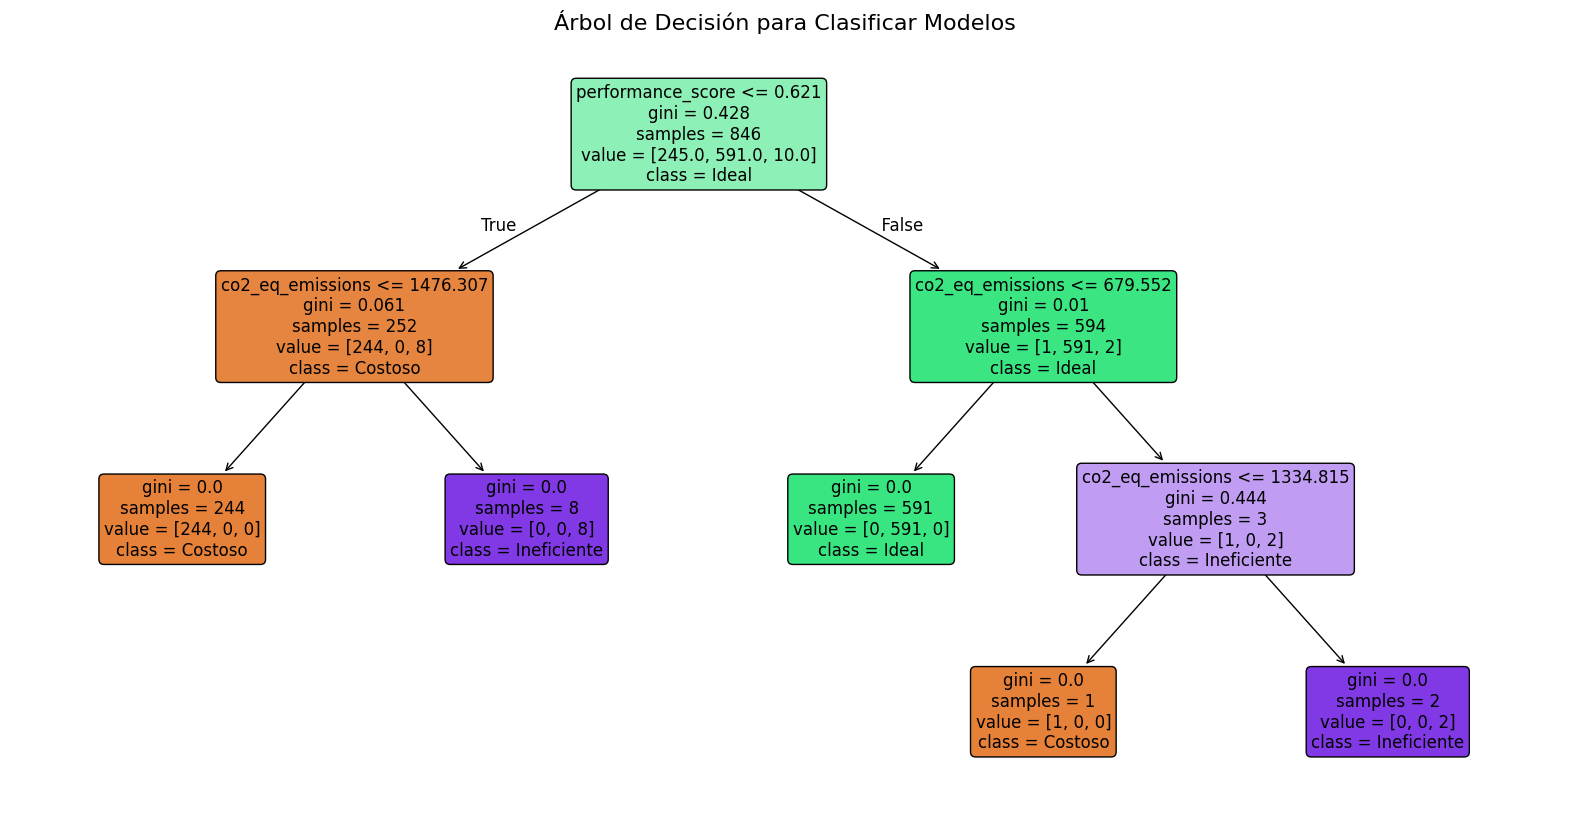

In [15]:
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model, 
    feature_names=features, 
    class_names=tree_model.classes_, # Nombres de las categorías
    filled=True, # Colorea los nodos según la clase mayoritaria
    rounded=True, # Nodos con bordes redondeados
    fontsize=12
)
plt.title("Árbol de Decisión para Clasificar Modelos", fontsize=16)
plt.show()

In [16]:
# Realizar predicciones en el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2%}\n")

# Mostrar un reporte de clasificación detallado
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 100.00%

Reporte de Clasificación:
              precision    recall  f1-score   support

     Costoso       1.00      1.00      1.00        62
       Ideal       1.00      1.00      1.00       148
 Ineficiente       1.00      1.00      1.00         2

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212

